## Iris鸢尾花分类
KNN中，用10折交叉验证寻找最佳的K

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# 模型性能的评价,本案例为分类问题，用正确率作为模型性能评价指标
from sklearn.metrics import accuracy_score 

#作图
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

#显示中文
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [2]:
#读取数据,csv文件没有列名，增加列名
feat_names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'species']

dpath = "./data/"
df = pd.read_csv(dpath + "iris.csv", names = feat_names)

#通过观察前5行，了解数据每列（特征）的概况
df.head()

,sepal-length,sepal-width,petal-length,petal-width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
# 数据总体信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal-length    150 non-null float64
sepal-width     150 non-null float64
petal-length    150 non-null float64
petal-width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In [4]:
#标签字符串映射为整数（在此并不一定需要）
target_map = {'Iris-setosa':0, 
              'Iris-versicolor':1,
              'Iris-virginica':2 }  #2

# Use the pandas apply method to numerically encode our attrition target variable
df['species'] = df['species'].apply(lambda x: target_map[x])

In [5]:
# 从原始数据中分离输入特征x和输出y
y = df['species']
X = df.drop('species', axis = 1)

In [6]:
corr_mat = X.corr()
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

,sepal-length,sepal-width,petal-length,petal-width
sepal-length,0.000000,-0.109369,0.871754,0.817954
sepal-width,-0.109369,0.000000,-0.420516,-0.356544
petal-length,0.871754,-0.420516,0.000000,0.962757
petal-width,0.817954,-0.356544,0.962757,0.000000


In [7]:
#将数据分割训练数据与测试数据,分类数据，跳用分层采样
from sklearn.model_selection import train_test_split

# 随机采样20%的数据构建测试集，其余作为训练样本
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4, stratify=y ) 

In [8]:
# 特征缩放:数据标准化
from sklearn.preprocessing import StandardScaler

#模型训练
scaler = StandardScaler()

#特征缩放
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### PCA

In [9]:
pca = PCA()

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

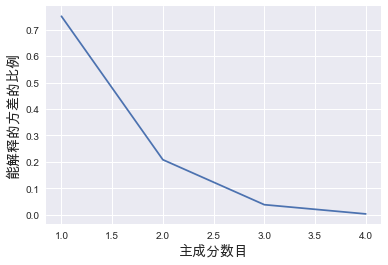

In [10]:
#explained_variance_：每个主成分能解释的方差的的百分比，即X的协方差矩阵的特征值
#explained_variance_ratio_：每个主成分能解释的方差的的百分比
# 绘制不同PCA维数下模型的性能，找到最佳模型／参数（分数最高）

x = np.arange(1, len(pca.explained_variance_ratio_)+1)
plt.plot( x, pca.explained_variance_ratio_)

#ax = plt.axes()
#ax.set_facecolor("white")

plt.xlabel(u"主成分数目", fontsize = 14)
plt.ylabel(u"能解释的方差的比例", fontsize = 14)

plt.show()

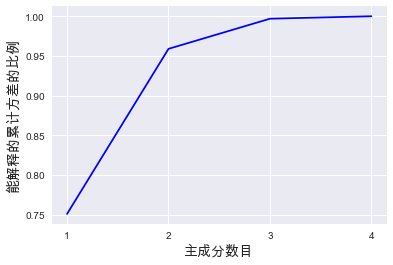

In [11]:
sum_explained_variance_ratio_ = np.zeros(len(pca.explained_variance_ratio_))

sum_explained_variance_ratio_[0] = pca.explained_variance_ratio_[0]
for i in range(1,X_train.shape[1]): 
    sum_explained_variance_ratio_[i] = sum_explained_variance_ratio_[i-1] + pca.explained_variance_ratio_[i]

ax = plt.axes()
#ax.set_facecolor("white")
#ax.grid()

plt.xlabel(u"主成分数目", fontsize = 14)
plt.ylabel(u"能解释的累计方差的比例", fontsize = 14)
plt.plot( x, sum_explained_variance_ratio_,'b-')

plt.xticks(range(1,5))
#plt.grid()

plt.show()

In [12]:
sum_explained_variance_ratio_

array([ 0.75079965,  0.95890343,  0.99688327,  1.        ])

## 降维到2个维度，表达的主成分有95.9%，降维到3个维度，表达的主成分有99.7%

In [13]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)

    plt.xticks([])
    plt.yticks([])
    plt.title(title, fontsize = 14)
    
    plt.scatter(data[:, 0], data[:, 1],
            c=label, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 3))
    plt.xlabel(u'成分1', fontsize = 14)
    plt.ylabel(u'成分2', fontsize = 14)
    plt.grid()

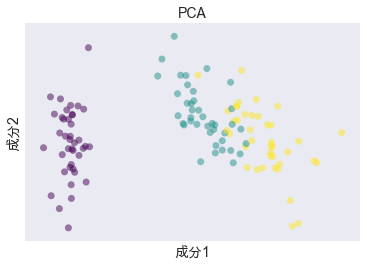

In [14]:
plot_embedding(X_train_pca[:,0:2], y_train,u'PCA')

只利用了两个维度的数据，就将鸢尾花进行了区分，且效果非常好，这就是PCA主成分分析的意义所在~

In [15]:
# 一个参数点（PCA维数为n）的模型训练和测试，得到该参数下模型在校验集上的预测性能
def n_component_analysis(n, X_train, y_train):
    print("PCA with n_components: {}".format(n));
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    
    # 利用SVC训练
    #设置超参数搜索范围
    C_s = np.logspace(-1, 3, 5)
    tuned_parameters = dict(C = C_s)

    #生成学习器实例
    clf =  LinearSVC()

    #生成GridSearchCV实例
    grid= GridSearchCV(clf, tuned_parameters,cv=10, scoring='accuracy')

    #训练，交叉验证对超参数调优
    grid.fit(X_train_pca,y_train)
    
    # 返回accuracy
    accuracy = grid.best_score_
    print('best SVC parameter:', grid.best_params_)
    
    return accuracy

In [16]:
# 设置超参数（PCA维数）搜索范围
n_s = np.arange(1, len(pca.explained_variance_ratio_)+1)
accuracys = []
for n in n_s:
    acc = n_component_analysis(n, X_train, y_train)
    accuracys.append(acc)

PCA with n_components: 1
('best SVC parameter:', {'C': 1.0})
PCA with n_components: 2
('best SVC parameter:', {'C': 100.0})
PCA with n_components: 3
('best SVC parameter:', {'C': 10.0})
PCA with n_components: 4
('best SVC parameter:', {'C': 10.0})


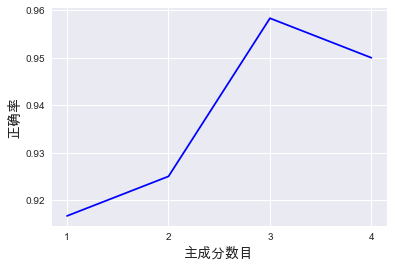

In [17]:
# 绘制不同PCA维数下模型的性能，找到最佳模型／参数（分数最高）
plt.xticks(n_s)
plt.plot(n_s, np.array(accuracys), 'b-')

plt.xlabel(u'主成分数目', fontsize = 14)
plt.ylabel(u'正确率', fontsize = 14)

In [18]:
accuracys

[0.91666666666666663,
 0.92500000000000004,
 0.95833333333333337,
 0.94999999999999996]

In [19]:
#对原始数据采用SVM分类器
#设置超参数搜索范围
C_s = np.logspace(-1, 3, 5)
tuned_parameters = dict(C = C_s)

#生成学习器实例
clf =  LinearSVC()

#生成GridSearchCV实例
grid= GridSearchCV(clf, tuned_parameters,cv=10, scoring='accuracy')

#训练，交叉验证对超参数调优
grid.fit(X_train,y_train)
    
# 返回accuracy
accuracy = grid.best_score_
print('best SVC best_params:', grid.best_params_)

('best SVC best_params:', {'C': 100.0})


In [20]:
accuracy

0.95833333333333337

In [21]:
#测试集上测试
y_test_pred = grid.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)
acc

0.93333333333333335